Populating the interactive namespace from numpy and matplotlib
Cu_orbs =  ['d3z2r2', 'dx2y2', 'dxy', 'dxz', 'dyz']
O1_orbs =  ['px']
O2_orbs =  ['py']
symmetries =  ['1A1']
E_1S =  12.66
E_1G =  8.26
E_1D =  7.21
E_3P =  7.55
E_3F =  5.3
Mc= 6
VS.dim =  2159
No. of states with count_upup, count_updn, count_dnup, count_dndn: 538 555 528 538
start create_singlet_triplet_basis_change_matrix
ep= 3.5  tpd= 1.2  tpp= 0.6  Upp= 0
start create_tpd_nn_matrix
start create_tpp_nn_matrix
start create_edep_diag_matrix
start computing A_dd(w) for sym 1A1
orbitals in sym  1A1 =  [('dyz', 'dyz'), ('dxz', 'dxz'), ('dxy', 'dxy'), ('d3z2r2', 'd3z2r2'), ('dx2y2', 'dx2y2')]
dd_state_indices 8 , state: S=  0  Sz=  0 orb=  dx2y2 dx2y2
start getting ground state
lowest eigenvalue of H =  [-5.11698689 -4.57625567 -4.57625567 -4.57625567 -4.02705917 -4.57625567
 -4.57625567 -3.54184162 -4.57625567 -3.31574097 -3.18486375 -3.18462871
 -3.31342173 -3.31342173 -3.18486375 -3.31342173 -2.8788103  -3.18486375
 -2.80

state  dx2y2 0 0 dx2y2 2 2 S= 1 Sz= 1 , weight =  0.009108605589337683
state  dx2y2 0 1 py 2 2 S= 1 Sz= -1 , weight =  0.010314515455417885
state  dx2y2 0 1 py 2 2 S= 1 Sz= 0 , weight =  0.0057507332559075175
state  dx2y2 0 1 py 2 2 S= 1 Sz= 1 , weight =  0.0025807067144606862
state  dx2y2 1 0 px 2 2 S= 1 Sz= -1 , weight =  0.012930453425595862
state  dx2y2 1 0 px 2 2 S= 1 Sz= 0 , weight =  0.016342776905728475
state  dx2y2 1 0 px 2 2 S= 1 Sz= 1 , weight =  0.002541083957199955
state  dx2y2 0 0 py 2 3 S= 1 Sz= -1 , weight =  0.008005565136069499
state  dx2y2 0 0 py 2 3 S= 1 Sz= 0 , weight =  0.007637321653393655
state  py 0 1 py 2 3 S= 1 Sz= -1 , weight =  0.003442248709482358
state  px 1 0 py 2 3 S= 1 Sz= -1 , weight =  0.003274646455793636
state  px 1 0 py 2 3 S= 1 Sz= 0 , weight =  0.004767811450006666
state  dx2y2 0 0 dx2y2 2 4 S= 1 Sz= -1 , weight =  0.007259205278712198
state  dx2y2 0 0 dx2y2 2 4 S= 1 Sz= 0 , weight =  0.009125252805903056
state  dx2y2 0 1 py 2 4 S= 1 Sz= -1 , we

state  dx2y2 0 0 px 5 0 S= 1 Sz= -1 , weight =  0.00433825834282797
state  dx2y2 0 0 px 5 0 S= 1 Sz= 1 , weight =  0.0027072460228428517
state  px 1 0 px 5 0 S= 1 Sz= -1 , weight =  0.00329914172977775
state  dx2y2 1 0 px 6 0 S= 1 Sz= -1 , weight =  0.004338258342827965
state  dx2y2 1 0 px 6 0 S= 1 Sz= 1 , weight =  0.0027072460228428487
eigenvalue =  -4.5762556693326415
Compute the weights in GS (lowest Aw peak)
state  dx2y2 0 0 dx2y2 0 2 S= 1 Sz= 0 , weight =  0.01207264362015618
state  dx2y2 0 0 dx2y2 0 2 S= 1 Sz= 1 , weight =  0.01074181243539569
state  dx2y2 0 0 py 0 3 S= 1 Sz= 0 , weight =  0.003955781580089964
state  dx2y2 0 0 py 0 3 S= 1 Sz= 1 , weight =  0.0035197149113037484
state  dx2y2 0 0 dx2y2 0 4 S= 1 Sz= 0 , weight =  0.009121315724051615
state  dx2y2 0 0 dx2y2 0 4 S= 1 Sz= 1 , weight =  0.00811582498038832
state  dx2y2 0 1 py 0 4 S= 1 Sz= 0 , weight =  0.0039557815800899555
state  dx2y2 0 1 py 0 4 S= 1 Sz= 1 , weight =  0.003519714911303776
state  dx2y2 0 0 px 1 -2 S= 

state  dx2y2 0 1 py 4 2 S= 0 Sz= 0 , weight =  0.02394767399558697
state  dx2y2 0 0 px 5 0 S= 0 Sz= 0 , weight =  0.022434686916686142
state  px 0 1 py 5 0 S= 0 Sz= 0 , weight =  0.002505412525233558
state  px 1 0 px 5 0 S= 0 Sz= 0 , weight =  0.0044447347223129175
state  px 0 1 py 5 2 S= 0 Sz= 0 , weight =  0.0025054125252335687
state  px 1 0 py 6 -1 S= 0 Sz= 0 , weight =  0.0025054125252335626
state  dx2y2 0 0 dx2y2 6 0 S= 0 Sz= 0 , weight =  0.011753881417450195
state  dx2y2 1 0 px 6 0 S= 0 Sz= 0 , weight =  0.022434686916686153
state  px 1 0 py 6 1 S= 0 Sz= 0 , weight =  0.0025054125252335717
eigenvalue =  -3.1848637529560846
Compute the weights in GS (lowest Aw peak)
state  d3z2r2 0 0 dx2y2 0 0 S= 1 Sz= -1 , weight =  0.009052663138300915
state  d3z2r2 0 0 dx2y2 0 0 S= 1 Sz= 0 , weight =  0.0646930488885779
state  d3z2r2 0 0 dx2y2 0 0 S= 1 Sz= 1 , weight =  0.016525846245052555
state  d3z2r2 0 0 py 0 1 S= 1 Sz= -1 , weight =  0.0027104289346456304
state  d3z2r2 0 0 py 0 1 S= 1 Sz=

state  d3z2r2 0 0 dx2y2 2 0 S= 1 Sz= 0 , weight =  0.008393742030675392
state  d3z2r2 0 0 dx2y2 2 0 S= 1 Sz= 0 , weight =  0.008393742030676101
state  dx2y2 0 0 dx2y2 2 0 S= 1 Sz= 0 , weight =  0.003266065197857222
state  d3z2r2 0 1 py 2 0 S= 1 Sz= 0 , weight =  0.002780851181638015
state  dx2y2 0 1 py 2 0 S= 1 Sz= 0 , weight =  0.0035400304679883395
state  dx2y2 0 0 py 2 1 S= 1 Sz= 0 , weight =  0.0108967310005677
state  dx2y2 0 0 dx2y2 2 2 S= 1 Sz= -1 , weight =  0.004637452426325369
state  dx2y2 0 0 dx2y2 2 2 S= 1 Sz= 0 , weight =  0.07812166887339017
state  dx2y2 0 0 dx2y2 2 2 S= 1 Sz= 1 , weight =  0.006905657826861069
state  dx2y2 0 1 py 2 2 S= 1 Sz= 0 , weight =  0.010896731000567947
state  dx2y2 1 0 px 2 2 S= 1 Sz= 0 , weight =  0.012070736290709493
state  dx2y2 0 0 py 2 3 S= 1 Sz= 0 , weight =  0.007217832781035249
state  py 0 1 py 2 3 S= 1 Sz= 0 , weight =  0.0034068847986499836
state  dx2y2 0 0 dx2y2 2 4 S= 1 Sz= 0 , weight =  0.004136115244931747
state  dx2y2 0 1 py 2 4 S= 

state  dx2y2 0 0 px 5 0 S= 0 Sz= 0 , weight =  0.004477955201575781
state  px 1 0 px 5 0 S= 0 Sz= 0 , weight =  0.004318826859594052
state  dx2y2 0 0 dx2y2 6 0 S= 0 Sz= 0 , weight =  0.0031122618737429164
state  d3z2r2 1 0 px 6 0 S= 0 Sz= 0 , weight =  0.004812292055778561
state  dx2y2 1 0 px 6 0 S= 0 Sz= 0 , weight =  0.0044779552015756004
eigenvalue =  -3.184863752955759
Compute the weights in GS (lowest Aw peak)
state  d3z2r2 0 0 dx2y2 0 0 S= 1 Sz= -1 , weight =  0.06109632865565613
state  d3z2r2 0 0 dx2y2 0 0 S= 1 Sz= 1 , weight =  0.028784380257489913
state  d3z2r2 0 0 py 0 1 S= 1 Sz= -1 , weight =  0.018292656476776113
state  d3z2r2 0 0 py 0 1 S= 1 Sz= 1 , weight =  0.008618239287581354
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= -1 , weight =  0.040238959456028095
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= 1 , weight =  0.018957825054858022
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= -1 , weight =  0.040238959456028484
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= 1 , weight =  0.018957825054858005
state  d

state  dx2y2 0 0 px 1 4 S= 1 Sz= -1 , weight =  0.005598095760618998
state  dx2y2 0 0 px 1 4 S= 1 Sz= 0 , weight =  0.007320495574373727
state  dx2y2 0 0 dx2y2 2 -4 S= 1 Sz= -1 , weight =  0.002973742044116084
state  dx2y2 0 0 dx2y2 2 -4 S= 1 Sz= 0 , weight =  0.002747049188429335
state  dx2y2 1 0 px 2 -4 S= 1 Sz= -1 , weight =  0.005007398138238768
state  dx2y2 1 0 px 2 -4 S= 1 Sz= 0 , weight =  0.00425567830403721
state  dx2y2 0 0 py 2 -3 S= 1 Sz= 0 , weight =  0.005265296196194834
state  dx2y2 0 0 py 2 -3 S= 1 Sz= 1 , weight =  0.003062782679635742
state  dx2y2 0 0 dx2y2 2 -2 S= 1 Sz= -1 , weight =  0.023291804093008874
state  dx2y2 0 0 dx2y2 2 -2 S= 1 Sz= 0 , weight =  0.044938256453240615
state  dx2y2 0 0 dx2y2 2 -2 S= 1 Sz= 1 , weight =  0.01857962109412013
state  dx2y2 0 1 py 2 -2 S= 1 Sz= 0 , weight =  0.005265296196194792
state  dx2y2 0 1 py 2 -2 S= 1 Sz= 1 , weight =  0.0030627826796357518
state  dx2y2 1 0 px 2 -2 S= 1 Sz= -1 , weight =  0.003664962784942855
state  dx2y2 1 0 

state  dx2y2 0 0 px 1 -2 S= 0 Sz= 0 , weight =  0.003808900477966234
state  px 0 1 py 1 -2 S= 0 Sz= 0 , weight =  0.004256971795462408
state  d3z2r2 0 0 px 1 2 S= 0 Sz= 0 , weight =  0.019199614574090307
state  dx2y2 0 0 px 1 2 S= 0 Sz= 0 , weight =  0.0030303307402701498
state  d3z2r2 0 0 px 1 4 S= 0 Sz= 0 , weight =  0.012297076551473836
state  px 0 1 py 1 4 S= 0 Sz= 0 , weight =  0.003636559325450617
state  d3z2r2 0 0 dx2y2 2 -4 S= 0 Sz= 0 , weight =  0.01445424785198476
state  d3z2r2 0 0 dx2y2 2 -4 S= 0 Sz= 0 , weight =  0.014454247851985248
state  d3z2r2 1 0 px 2 -4 S= 0 Sz= 0 , weight =  0.013399386325588456
state  d3z2r2 0 0 py 2 -3 S= 0 Sz= 0 , weight =  0.012623205076620727
state  px 1 0 py 2 -3 S= 0 Sz= 0 , weight =  0.004256971795462396
state  d3z2r2 0 0 dx2y2 2 -2 S= 0 Sz= 0 , weight =  0.056636765467533864
state  d3z2r2 0 0 dx2y2 2 -2 S= 0 Sz= 0 , weight =  0.05663676546753413
state  d3z2r2 0 1 py 2 -2 S= 0 Sz= 0 , weight =  0.012623205076620509
state  d3z2r2 1 0 px 2 -2 S

state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.020283476830534705
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 0 , weight =  0.03148140098551479
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 1 , weight =  0.0037042043919312618
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.020283476830535576
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 0 , weight =  0.031481400985515696
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 1 , weight =  0.0037042043919325077
state  dx2y2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.003479193873694585
state  dx2y2 0 0 dx2y2 4 0 S= 1 Sz= 0 , weight =  0.005399956741106588
state  d3z2r2 0 1 py 4 0 S= 1 Sz= -1 , weight =  0.003730576341074445
state  d3z2r2 0 1 py 4 0 S= 1 Sz= 0 , weight =  0.0063413511820080756
state  dx2y2 0 1 py 4 0 S= 1 Sz= 0 , weight =  0.003918135326295156
state  d3z2r2 1 0 px 4 0 S= 1 Sz= -1 , weight =  0.006027355066292167
state  d3z2r2 1 0 px 4 0 S= 1 Sz= 0 , weight =  0.009354884436694298
state  d3z2r2 0 0 py 4 1 S= 1 Sz= -1 , weight =  0.003976748577025733
state

state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.04624948277363317
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 0 , weight =  0.024645046251063573
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 1 , weight =  0.02244062214645212
state  d3z2r2 0 1 py 4 0 S= 1 Sz= -1 , weight =  0.007200961188691262
state  d3z2r2 0 1 py 4 0 S= 1 Sz= 0 , weight =  0.0038371893241711166
state  d3z2r2 0 1 py 4 0 S= 1 Sz= 1 , weight =  0.0034939644604803106
state  d3z2r2 1 0 px 4 0 S= 1 Sz= -1 , weight =  0.011091597101915013
state  d3z2r2 1 0 px 4 0 S= 1 Sz= 0 , weight =  0.005910399580310817
state  d3z2r2 1 0 px 4 0 S= 1 Sz= 1 , weight =  0.005381732392186513
state  d3z2r2 0 0 py 4 1 S= 1 Sz= -1 , weight =  0.007200961188691119
state  d3z2r2 0 0 py 4 1 S= 1 Sz= 0 , weight =  0.003837189324170803
state  d3z2r2 0 0 py 4 1 S= 1 Sz= 1 , weight =  0.0034939644604805903
state  d3z2r2 0 0 dx2y2 4 2 S= 1 Sz= -1 , weight =  0.004759646995289481
state  d3z2r2 0 0 dx2y2 4 2 S= 1 Sz= 0 , weight =  0.0025362817766368955
state  d3z2r

state  d3z2r2 1 0 px 2 4 S= 1 Sz= -1 , weight =  0.006575690831514585
state  d3z2r2 1 0 px 2 4 S= 1 Sz= 1 , weight =  0.006962156036696874
state  d3z2r2 0 0 px 3 0 S= 1 Sz= -1 , weight =  0.01012849694072201
state  d3z2r2 0 0 px 3 0 S= 1 Sz= 1 , weight =  0.01072376696613501
state  d3z2r2 0 0 dx2y2 4 -2 S= 1 Sz= -1 , weight =  0.004346359643948838
state  d3z2r2 0 0 dx2y2 4 -2 S= 1 Sz= 1 , weight =  0.004601803036078508
state  d3z2r2 0 0 dx2y2 4 -2 S= 1 Sz= -1 , weight =  0.004346359643949112
state  d3z2r2 0 0 dx2y2 4 -2 S= 1 Sz= 1 , weight =  0.004601803036078592
state  d3z2r2 0 0 py 4 -1 S= 1 Sz= -1 , weight =  0.006575690831514524
state  d3z2r2 0 0 py 4 -1 S= 1 Sz= 1 , weight =  0.00696215603669702
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.04223357019539299
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 0 , weight =  0.0063858677189899985
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 1 , weight =  0.044715713256760624
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.04223357019539083
s

state  d3z2r2 0 0 d3z2r2 2 0 S= 1 Sz= -1 , weight =  0.005074906475006053
state  dx2y2 0 0 dx2y2 2 0 S= 1 Sz= -1 , weight =  0.0682536623168058
state  dx2y2 0 0 dx2y2 2 0 S= 1 Sz= 0 , weight =  0.01999385430247575
state  dx2y2 0 0 dx2y2 2 0 S= 1 Sz= 1 , weight =  0.016642900537113085
state  dx2y2 0 1 py 2 0 S= 1 Sz= -1 , weight =  0.002954080514739211
state  dx2y2 0 1 py 2 0 S= 1 Sz= 1 , weight =  0.0025946311777212865
state  dx2y2 1 0 px 2 0 S= 1 Sz= -1 , weight =  0.005526323749001479
state  d3z2r2 0 0 py 2 1 S= 1 Sz= -1 , weight =  0.004805822577522128
state  dx2y2 0 0 py 2 1 S= 1 Sz= -1 , weight =  0.006228018406973023
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= -1 , weight =  0.034358464802536376
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= 0 , weight =  0.008509033258173544
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= 1 , weight =  0.006668745339693838
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= -1 , weight =  0.034358464802536265
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= 0 , weight =  0.008509033258174047
state  

state  dx2y2 0 0 dxy 2 2 S= 1 Sz= 1 , weight =  0.006322733896674617
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= -1 , weight =  0.0028609854359657183
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 0 , weight =  0.003489317097670379
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 1 , weight =  0.003345394607152541
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= -1 , weight =  0.0075603602734393505
state  dx2y2 0 0 dyz 2 2 S= 0 Sz= 0 , weight =  0.006950316066166416
state  dxy 0 1 py 2 2 S= 1 Sz= 1 , weight =  0.0030983859007764477
state  dyz 0 1 py 2 2 S= 1 Sz= -1 , weight =  0.0037048710350335687
state  dyz 0 1 py 2 2 S= 0 Sz= 0 , weight =  0.003405925610229437
state  dxy 1 0 px 2 2 S= 1 Sz= 1 , weight =  0.0030983859007764278
state  dyz 1 0 px 2 2 S= 1 Sz= -1 , weight =  0.003704871035033566
state  dyz 1 0 px 2 2 S= 0 Sz= 0 , weight =  0.003405925610229428
state  dyz 0 0 px 3 0 S= 1 Sz= -1 , weight =  0.002546179479619828
state  dx2y2 0 0 dyz 4 0 S= 1 Sz= -1 , weight =  0.0029646910756198266
state  dx2y2 0 0 dyz 4 0 S= 0 Sz= 0 , weigh

state  dx2y2 0 0 dyz 0 2 S= 1 Sz= 0 , weight =  0.006805202152753622
state  dx2y2 0 0 dyz 0 2 S= 1 Sz= 1 , weight =  0.003619542354196884
state  dxy 0 1 py 0 2 S= 1 Sz= 0 , weight =  0.003040566427200887
state  dxz 0 1 py 0 2 S= 0 Sz= 0 , weight =  0.0039505434859171415
state  dxz 0 1 py 0 2 S= 1 Sz= 0 , weight =  0.0032959568074614255
state  dyz 0 1 py 0 2 S= 0 Sz= 0 , weight =  0.007940712311305406
state  dyz 0 1 py 0 2 S= 1 Sz= 0 , weight =  0.0031077873711716085
state  dyz 0 0 py 0 3 S= 0 Sz= 0 , weight =  0.0034321264957368268
state  dx2y2 0 0 dyz 0 4 S= 0 Sz= 0 , weight =  0.003996259837043511
state  dx2y2 0 0 dyz 0 4 S= 0 Sz= 0 , weight =  0.0039962598370438815
state  dyz 0 1 py 0 4 S= 0 Sz= 0 , weight =  0.0034321264957370506
state  dyz 0 0 px 1 -2 S= 0 Sz= 0 , weight =  0.004993986537243708
state  dxy 0 0 px 1 0 S= 1 Sz= 0 , weight =  0.003040566427200864
state  dxz 0 0 px 1 0 S= 0 Sz= 0 , weight =  0.003950543485917118
state  dxz 0 0 px 1 0 S= 1 Sz= 0 , weight =  0.0032959568

state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 1 , weight =  0.004699175027142558
state  dx2y2 0 0 dxy 2 2 S= 0 Sz= 0 , weight =  0.01226699292731521
state  dx2y2 0 0 dxy 2 2 S= 1 Sz= 1 , weight =  0.004195529726082538
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= -1 , weight =  0.005815215469352438
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 0 , weight =  0.004033178373628708
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 1 , weight =  0.004699175027142627
state  dxy 0 1 py 2 2 S= 0 Sz= 0 , weight =  0.006011304374347813
state  dxz 0 1 py 2 2 S= 1 Sz= -1 , weight =  0.0028496821018665266
state  dxy 1 0 px 2 2 S= 0 Sz= 0 , weight =  0.006011304374347832
state  dxz 1 0 px 2 2 S= 1 Sz= -1 , weight =  0.002849682101866491
state  dxy 0 0 px 3 0 S= 0 Sz= 0 , weight =  0.004131280063186875
state  dx2y2 0 0 dxy 4 0 S= 0 Sz= 0 , weight =  0.004810332198594574
state  dx2y2 0 0 dxy 4 0 S= 0 Sz= 0 , weight =  0.004810332198594668
state  dxy 1 0 px 4 0 S= 0 Sz= 0 , weight =  0.004131280063186939
eigenvalue =  -2.63027736850617
Compute the weigh

state  d3z2r2 0 0 dx2y2 2 0 S= 1 Sz= -1 , weight =  0.0026597136627212713
state  d3z2r2 0 0 dx2y2 2 0 S= 1 Sz= 0 , weight =  0.004082119322953937
state  d3z2r2 1 0 px 2 0 S= 1 Sz= -1 , weight =  0.008561276388418413
state  d3z2r2 1 0 px 2 0 S= 1 Sz= 0 , weight =  0.013139817366111242
state  d3z2r2 1 0 px 2 0 S= 1 Sz= 1 , weight =  0.004978779672932973
state  d3z2r2 0 0 dx2y2 2 4 S= 1 Sz= -1 , weight =  0.004193372089998217
state  d3z2r2 0 0 dx2y2 2 4 S= 1 Sz= 0 , weight =  0.006435972968391161
state  d3z2r2 0 0 dx2y2 2 4 S= 1 Sz= -1 , weight =  0.004193372089998228
state  d3z2r2 0 0 dx2y2 2 4 S= 1 Sz= 0 , weight =  0.006435972968391079
state  d3z2r2 1 0 px 2 4 S= 1 Sz= -1 , weight =  0.0038157526708233404
state  d3z2r2 1 0 px 2 4 S= 1 Sz= 0 , weight =  0.005856403990965542
state  d3z2r2 0 0 dx2y2 4 -2 S= 1 Sz= -1 , weight =  0.004193372090005392
state  d3z2r2 0 0 dx2y2 4 -2 S= 1 Sz= 0 , weight =  0.006435972968387692
state  d3z2r2 0 0 dx2y2 4 -2 S= 1 Sz= -1 , weight =  0.00419337209000

state  d3z2r2 1 0 px 4 2 S= 1 Sz= -1 , weight =  0.0070558445565675944
state  d3z2r2 1 0 px 4 2 S= 1 Sz= 0 , weight =  0.012377624130492147
eigenvalue =  -2.1774294588374468
Compute the weights in GS (lowest Aw peak)
state  d3z2r2 0 0 dx2y2 0 0 S= 1 Sz= -1 , weight =  0.06572313756776332
state  d3z2r2 0 0 dx2y2 0 0 S= 1 Sz= 1 , weight =  0.13532339398398335
state  d3z2r2 0 0 py 0 1 S= 1 Sz= -1 , weight =  0.008702944541855773
state  d3z2r2 0 0 py 0 1 S= 1 Sz= 1 , weight =  0.017919290475809004
state  dx2y2 0 0 py 0 1 S= 1 Sz= 1 , weight =  0.0032692347577648073
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= -1 , weight =  0.002703725408888088
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= 1 , weight =  0.005566948144467496
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= -1 , weight =  0.0027037254088879024
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= 1 , weight =  0.005566948144467578
state  d3z2r2 0 1 py 0 2 S= 1 Sz= -1 , weight =  0.008702944541855872
state  d3z2r2 0 1 py 0 2 S= 1 Sz= 1 , weight =  0.017919290475809004
st

state  d3z2r2 0 0 py 2 3 S= 0 Sz= 0 , weight =  0.0039353749992025655
state  d3z2r2 0 0 dx2y2 2 4 S= 0 Sz= 0 , weight =  0.01385737957487702
state  d3z2r2 0 0 dx2y2 2 4 S= 0 Sz= 0 , weight =  0.013857379574875747
state  d3z2r2 0 1 py 2 4 S= 0 Sz= 0 , weight =  0.00393537499920278
state  d3z2r2 1 0 px 2 4 S= 0 Sz= 0 , weight =  0.01249271677214814
state  dx2y2 1 0 px 2 4 S= 0 Sz= 0 , weight =  0.0025806333458202988
state  d3z2r2 0 0 px 3 -2 S= 0 Sz= 0 , weight =  0.006931048748455511
state  d3z2r2 0 0 px 3 0 S= 0 Sz= 0 , weight =  0.004421661237512943
state  d3z2r2 0 0 px 3 2 S= 0 Sz= 0 , weight =  0.0029844673355633945
state  d3z2r2 0 0 dx2y2 4 -2 S= 0 Sz= 0 , weight =  0.0039841139126863805
state  d3z2r2 0 0 dx2y2 4 -2 S= 0 Sz= 0 , weight =  0.003984113912686172
state  d3z2r2 1 0 px 4 -2 S= 0 Sz= 0 , weight =  0.006931048748456119
state  d3z2r2 0 0 py 4 -1 S= 0 Sz= 0 , weight =  0.008779515748324347
state  d3z2r2 0 0 dx2y2 4 0 S= 0 Sz= 0 , weight =  0.09725009719851305
state  d3z2r2 0

state  dx2y2 0 0 dxz 0 2 S= 1 Sz= 0 , weight =  0.003595990189006646
state  dx2y2 0 0 dyz 0 2 S= 1 Sz= -1 , weight =  0.011378361911072282
state  dx2y2 0 0 dyz 0 2 S= 1 Sz= 1 , weight =  0.003729410112550587
state  dxy 0 0 py 0 3 S= 0 Sz= 0 , weight =  0.005974515361723693
state  dyz 0 0 py 0 3 S= 1 Sz= -1 , weight =  0.006687105500150997
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= -1 , weight =  0.006203808633153844
state  dx2y2 0 0 dxy 0 4 S= 0 Sz= 0 , weight =  0.02293365748146729
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= -1 , weight =  0.006603411639182006
state  dx2y2 0 0 dxz 0 4 S= 0 Sz= 0 , weight =  0.005072613721622886
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 0 , weight =  0.00811236662628398
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 1 , weight =  0.0055743125985144625
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= -1 , weight =  0.02566899200986483
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 0 , weight =  0.004385817633417488
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 1 , weight =  0.008413355026738515
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= -1 

state  d3z2r2 0 0 dx2y2 0 6 S= 0 Sz= 0 , weight =  0.005170480500814591
state  d3z2r2 0 0 dx2y2 0 6 S= 0 Sz= 0 , weight =  0.005170480500814254
state  dx2y2 0 0 dx2y2 0 6 S= 0 Sz= 0 , weight =  0.017428744578726636
state  d3z2r2 0 1 py 0 6 S= 0 Sz= 0 , weight =  0.002655009975542846
state  dx2y2 0 1 py 0 6 S= 0 Sz= 0 , weight =  0.010128570348557492
state  dx2y2 0 0 px 1 -2 S= 0 Sz= 0 , weight =  0.005609529387786656
state  d3z2r2 0 0 px 1 0 S= 0 Sz= 0 , weight =  0.009749370818169718
state  dx2y2 0 0 px 1 2 S= 0 Sz= 0 , weight =  0.005609529387786548
state  d3z2r2 0 0 d3z2r2 2 -4 S= 0 Sz= 0 , weight =  0.002884714871009522
state  d3z2r2 0 0 dx2y2 2 -4 S= 0 Sz= 0 , weight =  0.010646475639485412
state  d3z2r2 0 0 dx2y2 2 -4 S= 0 Sz= 0 , weight =  0.010646475639485847
state  dx2y2 0 0 dx2y2 2 -4 S= 0 Sz= 0 , weight =  0.004217453825034096
state  d3z2r2 0 0 py 2 -3 S= 0 Sz= 0 , weight =  0.008004604270809332
state  dx2y2 0 0 py 2 -3 S= 0 Sz= 0 , weight =  0.00454894434175039
state  d3z2r

state  dxz 0 1 py 0 6 S= 1 Sz= 0 , weight =  0.004234126968673116
state  dxz 0 0 px 1 -4 S= 1 Sz= -1 , weight =  0.002751569814346948
state  dxz 0 0 px 1 -4 S= 1 Sz= 0 , weight =  0.004827478096974632
state  dxz 0 0 px 1 4 S= 1 Sz= -1 , weight =  0.0027515698143469234
state  dxz 0 0 px 1 4 S= 1 Sz= 0 , weight =  0.004827478096974746
state  dx2y2 0 0 dxz 2 -4 S= 1 Sz= 0 , weight =  0.0026515627549949052
state  dx2y2 0 0 dxz 2 -4 S= 1 Sz= 0 , weight =  0.0026515627549949083
state  dxz 1 0 px 2 -4 S= 1 Sz= -1 , weight =  0.002751569814346932
state  dxz 1 0 px 2 -4 S= 1 Sz= 0 , weight =  0.004827478096974714
state  dx2y2 0 0 dxy 2 0 S= 1 Sz= -1 , weight =  0.003128009868042736
state  dx2y2 0 0 dxy 2 0 S= 0 Sz= 0 , weight =  0.003278691808631962
state  dx2y2 0 0 dxy 2 0 S= 1 Sz= 1 , weight =  0.002622168781796085
state  dx2y2 0 0 dxz 2 0 S= 1 Sz= -1 , weight =  0.0077153869299308765
state  dx2y2 0 0 dxz 2 0 S= 1 Sz= 0 , weight =  0.013536222566377274
state  dx2y2 0 0 dyz 2 0 S= 1 Sz= -1 , w

state  d3z2r2 0 0 dx2y2 2 -2 S= 1 Sz= 1 , weight =  0.005669158375936104
state  dx2y2 0 1 py 2 -2 S= 1 Sz= -1 , weight =  0.0025712397732084794
state  d3z2r2 0 0 d3z2r2 2 0 S= 1 Sz= -1 , weight =  0.0032051330942672327
state  dx2y2 0 0 dx2y2 2 0 S= 1 Sz= -1 , weight =  0.02525602085817906
state  dx2y2 0 0 dx2y2 2 0 S= 1 Sz= 0 , weight =  0.008493079256395307
state  dx2y2 0 0 dx2y2 2 0 S= 1 Sz= 1 , weight =  0.01570302788977439
state  dx2y2 1 0 px 2 0 S= 1 Sz= -1 , weight =  0.002968818213844124
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= -1 , weight =  0.009358310104700064
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= 0 , weight =  0.004322613950383676
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= 1 , weight =  0.009702388314792212
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= -1 , weight =  0.00935831010469847
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= 0 , weight =  0.004322613950384247
state  d3z2r2 0 0 dx2y2 2 2 S= 1 Sz= 1 , weight =  0.009702388314791529
state  d3z2r2 0 0 d3z2r2 2 4 S= 1 Sz= 1 , weight =  0.0026567989199

state  dx2y2 1 0 px 4 -2 S= 1 Sz= -1 , weight =  0.002778218586708215
state  d3z2r2 0 0 py 4 -1 S= 1 Sz= 1 , weight =  0.004706165278635568
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.01336974132163782
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 1 , weight =  0.033076784052722207
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.013369741321637593
state  d3z2r2 0 0 dx2y2 4 0 S= 1 Sz= 1 , weight =  0.03307678405272184
state  dx2y2 0 0 dx2y2 4 0 S= 1 Sz= -1 , weight =  0.004428182297291254
state  dx2y2 0 0 dx2y2 4 0 S= 1 Sz= 1 , weight =  0.010955337584321153
state  d3z2r2 0 1 py 4 0 S= 1 Sz= 1 , weight =  0.004706165278635655
state  d3z2r2 1 0 px 4 0 S= 1 Sz= 1 , weight =  0.002546168139123963
state  d3z2r2 0 0 py 4 1 S= 1 Sz= 1 , weight =  0.0047150695801931155
state  d3z2r2 0 0 d3z2r2 4 2 S= 1 Sz= 1 , weight =  0.003878303502450534
state  dx2y2 0 0 dx2y2 4 2 S= 1 Sz= -1 , weight =  0.008355490029994092
state  dx2y2 0 0 dx2y2 4 2 S= 1 Sz= 1 , weight =  0.005722853130318495
state

state  d3z2r2 0 0 dx2y2 0 6 S= 1 Sz= 0 , weight =  0.004547125990326491
state  d3z2r2 0 1 py 0 6 S= 1 Sz= 0 , weight =  0.00535310410329308
state  d3z2r2 0 0 px 1 -2 S= 1 Sz= 0 , weight =  0.0026890152935574014
state  d3z2r2 0 0 px 1 0 S= 1 Sz= 0 , weight =  0.005732262926127716
state  d3z2r2 0 0 px 1 2 S= 1 Sz= 0 , weight =  0.002689015293557553
state  d3z2r2 0 0 py 2 -3 S= 1 Sz= 0 , weight =  0.005513792764669553
state  d3z2r2 0 0 dx2y2 2 -2 S= 1 Sz= -1 , weight =  0.015851098531235865
state  d3z2r2 0 0 dx2y2 2 -2 S= 1 Sz= 0 , weight =  0.05470032571623449
state  d3z2r2 0 0 dx2y2 2 -2 S= 1 Sz= 1 , weight =  0.015672578994145953
state  d3z2r2 0 0 dx2y2 2 -2 S= 1 Sz= -1 , weight =  0.015851098531235328
state  d3z2r2 0 0 dx2y2 2 -2 S= 1 Sz= 0 , weight =  0.05470032571623456
state  d3z2r2 0 0 dx2y2 2 -2 S= 1 Sz= 1 , weight =  0.015672578994145606
state  d3z2r2 0 1 py 2 -2 S= 1 Sz= 0 , weight =  0.005513792764669407
state  d3z2r2 1 0 px 2 -2 S= 1 Sz= 0 , weight =  0.0026890152935575957
st

state  d3z2r2 0 0 d3z2r2 0 4 S= 1 Sz= 1 , weight =  0.006584128161530406
state  d3z2r2 0 0 dx2y2 0 4 S= 1 Sz= 0 , weight =  0.00447805359506375
state  d3z2r2 0 0 dx2y2 0 4 S= 1 Sz= 0 , weight =  0.0044780535950641
state  d3z2r2 0 1 py 0 4 S= 1 Sz= 0 , weight =  0.004895609726429763
state  dx2y2 0 0 dx2y2 0 6 S= 1 Sz= 0 , weight =  0.0033550799128081264
state  d3z2r2 0 0 px 1 -4 S= 1 Sz= 0 , weight =  0.00480610192492155
state  d3z2r2 0 0 px 1 -2 S= 1 Sz= 0 , weight =  0.00355009246390398
state  d3z2r2 0 0 px 1 2 S= 1 Sz= 0 , weight =  0.005916419828704264
state  d3z2r2 0 0 px 1 4 S= 1 Sz= 0 , weight =  0.00425450716454224
state  d3z2r2 0 0 dx2y2 2 -4 S= 1 Sz= -1 , weight =  0.0037713672541094764
state  d3z2r2 0 0 dx2y2 2 -4 S= 1 Sz= 0 , weight =  0.012245907103158002
state  d3z2r2 0 0 dx2y2 2 -4 S= 1 Sz= 1 , weight =  0.003791217832769337
state  d3z2r2 0 0 dx2y2 2 -4 S= 1 Sz= -1 , weight =  0.00377136725410917
state  d3z2r2 0 0 dx2y2 2 -4 S= 1 Sz= 0 , weight =  0.012245907103157998
sta

state  dxy 1 0 px 6 0 S= 1 Sz= 0 , weight =  0.0033044475125928565
eigenvalue =  -1.7883130534341143
Compute the weights in GS (lowest Aw peak)
state  dx2y2 0 0 dxy 0 0 S= 0 Sz= 0 , weight =  0.005976877192138001
state  dx2y2 0 0 dyz 0 0 S= 0 Sz= 0 , weight =  0.009109282133901688
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= -1 , weight =  0.023730739009617138
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= 0 , weight =  0.06179166496630363
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= 1 , weight =  0.005736575582098737
state  dx2y2 0 0 dxz 0 0 S= 1 Sz= -1 , weight =  0.015497263979216266
state  dx2y2 0 0 dxz 0 0 S= 1 Sz= 1 , weight =  0.013578718436555193
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= -1 , weight =  0.011440109521272444
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 0 , weight =  0.018449953835284735
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 1 , weight =  0.04372143331820832
state  dxy 0 0 py 0 1 S= 1 Sz= -1 , weight =  0.003293941496697596
state  dxy 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.008576982339237624
state  dyz 0 0 py 0 1 S= 1 Sz= 0

state  d3z2r2 0 1 py 4 2 S= 1 Sz= -1 , weight =  0.004791124822328545
state  d3z2r2 1 0 px 4 2 S= 1 Sz= -1 , weight =  0.003951900112896066
state  dx2y2 1 0 px 4 2 S= 1 Sz= -1 , weight =  0.0034260387676767028
state  dx2y2 0 0 dx2y2 6 0 S= 1 Sz= -1 , weight =  0.0034420206265362544
eigenvalue =  -1.7080617539952327
Compute the weights in GS (lowest Aw peak)
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= -1 , weight =  0.004202956607993619
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= 0 , weight =  0.0037839010786822613
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= -1 , weight =  0.004202956607993632
state  d3z2r2 0 0 dx2y2 0 2 S= 1 Sz= 0 , weight =  0.003783901078682257
state  dx2y2 0 0 px 1 -4 S= 1 Sz= -1 , weight =  0.0032539243534505037
state  dx2y2 0 0 px 1 -4 S= 1 Sz= 1 , weight =  0.0036236562194551457
state  d3z2r2 0 0 px 1 0 S= 1 Sz= -1 , weight =  0.006064866720749898
state  d3z2r2 0 0 px 1 0 S= 1 Sz= 1 , weight =  0.006731669154436058
state  dx2y2 0 0 px 1 4 S= 1 Sz= -1 , weight =  0.0032667594949670783

state  dx2y2 0 0 dyz 0 2 S= 1 Sz= 0 , weight =  0.003769264202762437
state  dx2y2 0 0 dyz 0 2 S= 1 Sz= 1 , weight =  0.012195214290373018
state  dxz 0 0 py 0 3 S= 1 Sz= 1 , weight =  0.004664635113097855
state  dyz 0 0 py 0 3 S= 1 Sz= -1 , weight =  0.003966591205260102
state  dyz 0 0 py 0 3 S= 1 Sz= 1 , weight =  0.007167172673363361
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= -1 , weight =  0.00741519535270778
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 0 , weight =  0.005403326698811609
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 1 , weight =  0.0027026576727286243
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= -1 , weight =  0.00714818075994666
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 1 , weight =  0.01790557685150004
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= -1 , weight =  0.015226079198529252
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 0 , weight =  0.008503263779087743
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 1 , weight =  0.027511768444767295
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= -1 , weight =  0.007415195352707775
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 0 , we

state  dx2y2 0 0 dyz 0 4 S= 1 Sz= -1 , weight =  0.0031035927834738176
state  dx2y2 0 0 dyz 0 4 S= 0 Sz= 0 , weight =  0.008979800822770017
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 0 , weight =  0.00809868591086937
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= -1 , weight =  0.018806999347368483
state  dx2y2 0 0 dxy 0 4 S= 0 Sz= 0 , weight =  0.007693257605824402
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 0 , weight =  0.020359782480736336
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 1 , weight =  0.008808585400279796
state  dx2y2 0 0 dxz 0 4 S= 0 Sz= 0 , weight =  0.015410252108534141
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 0 , weight =  0.0028492670076946517
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= -1 , weight =  0.0031035927834738492
state  dx2y2 0 0 dyz 0 4 S= 0 Sz= 0 , weight =  0.008979800822769843
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 0 , weight =  0.008098685910869723
state  dxy 0 1 py 0 4 S= 1 Sz= -1 , weight =  0.004899467370155908
state  dxy 0 1 py 0 4 S= 1 Sz= 0 , weight =  0.0053039875253570136
state  dxz 0 1 py 0 4 S= 0 Sz= 0 

state  dxz 0 1 py 2 -2 S= 0 Sz= 0 , weight =  0.01148406250222142
state  dxz 1 0 px 2 -2 S= 0 Sz= 0 , weight =  0.006192263455303328
state  dxz 0 0 py 2 -1 S= 0 Sz= 0 , weight =  0.006192263455303177
state  dxz 0 1 py 2 0 S= 0 Sz= 0 , weight =  0.006192263455303238
state  dxz 0 0 py 2 1 S= 0 Sz= 0 , weight =  0.006192263455303271
state  dx2y2 0 0 dxy 2 2 S= 1 Sz= -1 , weight =  0.01315074785459835
state  dx2y2 0 0 dxy 2 2 S= 0 Sz= 0 , weight =  0.012258106614776724
state  dx2y2 0 0 dxy 2 2 S= 1 Sz= 0 , weight =  0.006901386906461799
state  dx2y2 0 0 dxy 2 2 S= 1 Sz= 1 , weight =  0.014933198015689958
state  dx2y2 0 0 dxz 2 2 S= 0 Sz= 0 , weight =  0.06373205438307528
state  dx2y2 0 0 dyz 2 2 S= 0 Sz= 0 , weight =  0.005603918982493964
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 0 , weight =  0.006207194383006543
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 1 , weight =  0.005621222424970679
state  dx2y2 0 0 dxy 2 2 S= 1 Sz= -1 , weight =  0.013150747854597716
state  dx2y2 0 0 dxy 2 2 S= 0 Sz= 0 , weight = 

state  dxz 0 1 py 2 4 S= 1 Sz= 0 , weight =  0.003660139884671429
state  dyz 0 1 py 2 4 S= 1 Sz= 1 , weight =  0.002575431896488469
state  dxy 0 0 px 3 -2 S= 0 Sz= 0 , weight =  0.003625839041875963
state  dxy 0 0 px 3 -2 S= 1 Sz= 0 , weight =  0.0034232993155634945
state  dxy 0 0 px 3 -2 S= 1 Sz= 1 , weight =  0.003112605845918126
state  dxz 0 0 px 3 -2 S= 0 Sz= 0 , weight =  0.002539458408386348
state  dxz 0 0 px 3 -2 S= 1 Sz= 0 , weight =  0.0036601398846716963
state  dyz 0 0 px 3 -2 S= 1 Sz= 1 , weight =  0.0025754318964882617
state  dxy 0 0 px 3 2 S= 0 Sz= 0 , weight =  0.003625839041875658
state  dxy 0 0 px 3 2 S= 1 Sz= 0 , weight =  0.0034232993155630556
state  dxy 0 0 px 3 2 S= 1 Sz= 1 , weight =  0.003112605845918447
state  dxz 0 0 px 3 2 S= 0 Sz= 0 , weight =  0.0025394584083864493
state  dxz 0 0 px 3 2 S= 1 Sz= 0 , weight =  0.003660139884671437
state  dyz 0 0 px 3 2 S= 1 Sz= 1 , weight =  0.002575431896488435
state  dx2y2 0 0 dxy 4 -2 S= 0 Sz= 0 , weight =  0.00271246896752

state  dxy 0 0 py 2 -3 S= 1 Sz= 1 , weight =  0.003022790044031826
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= -1 , weight =  0.006281784497322161
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= 1 , weight =  0.016527902805334272
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 0 , weight =  0.004330648767169324
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 1 , weight =  0.006673466177879785
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= -1 , weight =  0.003426259787100319
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= 0 , weight =  0.0030561625865140273
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= 1 , weight =  0.01050810908666065
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= -1 , weight =  0.006281784497322625
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= 1 , weight =  0.01652790280533403
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 0 , weight =  0.004330648767169403
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 1 , weight =  0.0066734661778795334
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= -1 , weight =  0.003426259787099986
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= 0 , weight =  0.0030561625865140295
state  dx2y2 0 0 d

state  dx2y2 0 0 dyz 2 -4 S= 1 Sz= 0 , weight =  0.004221073770981556
state  dx2y2 0 0 dxy 2 -4 S= 1 Sz= -1 , weight =  0.003977135883636421
state  dx2y2 0 0 dxy 2 -4 S= 1 Sz= 0 , weight =  0.0033279149188294357
state  dx2y2 0 0 dyz 2 -4 S= 1 Sz= 0 , weight =  0.0042210737709815795
state  dxy 0 0 py 2 -3 S= 1 Sz= -1 , weight =  0.005316357434637736
state  dxy 0 0 py 2 -3 S= 1 Sz= 0 , weight =  0.004448524198872521
state  dyz 0 0 py 2 -3 S= 1 Sz= 0 , weight =  0.005642436562664163
state  dyz 0 0 py 2 -3 S= 1 Sz= 1 , weight =  0.003311101987899665
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= -1 , weight =  0.029503704031448447
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= 0 , weight =  0.024687569064704228
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 0 , weight =  0.008675305462880763
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 1 , weight =  0.005809819243625498
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= -1 , weight =  0.004214332821167092
state  dx2y2 0 0 dyz 2 -2 S= 0 Sz= 0 , weight =  0.0032503744376421733
state  dx2y2 0 0 dyz 2 -2

state  dx2y2 0 0 dyz 4 2 S= 0 Sz= 0 , weight =  0.0031813016154497806
state  dxy 1 0 px 4 2 S= 0 Sz= 0 , weight =  0.008917381843220976
state  dxz 1 0 px 4 2 S= 1 Sz= 1 , weight =  0.003813876513486305
state  dyz 1 0 px 4 2 S= 0 Sz= 0 , weight =  0.004252541776284272
eigenvalue =  -1.788313053434118
Compute the weights in GS (lowest Aw peak)
state  dx2y2 0 0 dxy 0 0 S= 0 Sz= 0 , weight =  0.004522745601218456
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= -1 , weight =  0.015391341081193218
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= 0 , weight =  0.004313715312167096
state  dx2y2 0 0 dxy 0 0 S= 1 Sz= 1 , weight =  0.041137873968951626
state  dx2y2 0 0 dxz 0 0 S= 1 Sz= -1 , weight =  0.05715317836901677
state  dx2y2 0 0 dxz 0 0 S= 1 Sz= 1 , weight =  0.04331021833687272
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= -1 , weight =  0.02729885838170919
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 0 , weight =  0.007882698132860739
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 1 , weight =  0.007620758197287604
state  dxy 0 0 py 0 1 S= 1 Sz= 1 , 

state  dx2y2 0 0 dxz 0 0 S= 1 Sz= 0 , weight =  0.06793559836467364
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 0 , weight =  0.01830247573314508
state  dx2y2 0 0 dyz 0 0 S= 1 Sz= 1 , weight =  0.005978196607124916
state  dxy 0 0 py 0 1 S= 0 Sz= 0 , weight =  0.008187457588100473
state  dxy 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.004456763636619821
state  dxz 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.009429790048497621
state  dyz 0 0 py 0 1 S= 1 Sz= 0 , weight =  0.002540472266172423
state  dx2y2 0 0 dxz 0 2 S= 1 Sz= 0 , weight =  0.0027225593411121475
state  dx2y2 0 0 dxz 0 2 S= 1 Sz= 0 , weight =  0.00272255934111196
state  dxy 0 1 py 0 2 S= 0 Sz= 0 , weight =  0.008187457588100492
state  dxy 0 1 py 0 2 S= 1 Sz= 0 , weight =  0.004456763636619834
state  dxz 0 1 py 0 2 S= 1 Sz= 0 , weight =  0.009429790048497498
state  dyz 0 1 py 0 2 S= 1 Sz= 0 , weight =  0.0025404722661724072
state  dx2y2 0 0 dxy 0 4 S= 0 Sz= 0 , weight =  0.019619242503219954
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 0 , weight =  0.010679545

state  dx2y2 0 0 dyz 0 4 S= 0 Sz= 0 , weight =  0.0038901147150450384
state  dyz 0 0 py 0 5 S= 1 Sz= -1 , weight =  0.0031609538159646684
state  dyz 0 1 py 0 6 S= 1 Sz= -1 , weight =  0.0031609538159646537
state  dxy 0 0 px 1 -4 S= 1 Sz= -1 , weight =  0.0028869988149759465
state  dxy 0 0 px 1 -4 S= 1 Sz= 1 , weight =  0.003096482936835698
state  dyz 0 0 px 1 -4 S= 1 Sz= -1 , weight =  0.004054000804384691
state  dxy 0 0 px 1 0 S= 1 Sz= -1 , weight =  0.0060831984250345385
state  dxy 0 0 px 1 0 S= 1 Sz= 1 , weight =  0.0065246026519970865
state  dyz 0 0 px 1 0 S= 1 Sz= -1 , weight =  0.008542189619335326
state  dxy 0 0 px 1 4 S= 1 Sz= -1 , weight =  0.0028869988149761144
state  dxy 0 0 px 1 4 S= 1 Sz= 1 , weight =  0.0030964829368356436
state  dyz 0 0 px 1 4 S= 1 Sz= -1 , weight =  0.004054000804384815
state  dx2y2 0 0 dxy 2 -4 S= 1 Sz= -1 , weight =  0.002808726353332355
state  dx2y2 0 0 dxy 2 -4 S= 1 Sz= 1 , weight =  0.003012530930812849
state  dx2y2 0 0 dyz 2 -4 S= 1 Sz= -1 , weigh

state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 0 , weight =  0.008842853739502813
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 1 , weight =  0.005913988373636208
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= -1 , weight =  0.03577038336659242
state  dx2y2 0 0 dyz 2 -2 S= 0 Sz= 0 , weight =  0.038588396854098435
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= 0 , weight =  0.00647658535771614
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= 1 , weight =  0.00867278802044864
state  dyz 0 1 py 2 -2 S= 1 Sz= -1 , weight =  0.006445568439410794
state  dyz 0 1 py 2 -2 S= 0 Sz= 0 , weight =  0.0069533544089027885
state  dyz 1 0 px 2 -2 S= 1 Sz= -1 , weight =  0.003475482468708232
state  dyz 1 0 px 2 -2 S= 0 Sz= 0 , weight =  0.0037492831817739574
state  dyz 0 0 py 2 -1 S= 1 Sz= -1 , weight =  0.0034754824687082586
state  dyz 0 0 py 2 -1 S= 0 Sz= 0 , weight =  0.003749283181774162
state  dyz 0 1 py 2 0 S= 1 Sz= -1 , weight =  0.003475482468708232
state  dyz 0 1 py 2 0 S= 0 Sz= 0 , weight =  0.003749283181773984
state  dyz 0 0 py 2 1 S= 1 Sz= -1 , weigh

state  dxz 0 0 py 2 -1 S= 1 Sz= 0 , weight =  0.003971792197222834
state  dyz 0 0 py 2 -1 S= 1 Sz= 0 , weight =  0.004288937852245625
state  dxz 0 1 py 2 0 S= 1 Sz= 0 , weight =  0.00397179219722286
state  dyz 0 1 py 2 0 S= 1 Sz= 0 , weight =  0.004288937852245792
state  dxz 0 0 py 2 1 S= 1 Sz= 0 , weight =  0.0039717921972228405
state  dyz 0 0 py 2 1 S= 1 Sz= 0 , weight =  0.0042889378522457736
state  dx2y2 0 0 dxy 2 2 S= 0 Sz= 0 , weight =  0.0029617016046784906
state  dx2y2 0 0 dxy 2 2 S= 1 Sz= 0 , weight =  0.017237670092519666
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= -1 , weight =  0.009736685666369574
state  dx2y2 0 0 dxz 2 2 S= 0 Sz= 0 , weight =  0.008558642196931551
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 0 , weight =  0.040878505596348556
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 1 , weight =  0.0037216733590425
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 0 , weight =  0.044142634178598816
state  dx2y2 0 0 dxy 2 2 S= 0 Sz= 0 , weight =  0.002961701604678733
state  dx2y2 0 0 dxy 2 2 S= 1 Sz= 0 , weight =  0

state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 0 , weight =  0.01378723742078807
state  dx2y2 0 0 dxz 0 4 S= 0 Sz= 0 , weight =  0.0029862121316263242
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 0 , weight =  0.010984598642777487
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 1 , weight =  0.00742753590939669
state  dx2y2 0 0 dxy 0 4 S= 0 Sz= 0 , weight =  0.0031651466338270514
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 0 , weight =  0.013787237420788006
state  dx2y2 0 0 dxz 0 4 S= 0 Sz= 0 , weight =  0.002986212131626261
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 0 , weight =  0.010984598642777487
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= 1 , weight =  0.007427535909397035
state  dxy 0 1 py 0 4 S= 1 Sz= 0 , weight =  0.006075704285746397
state  dxz 0 1 py 0 4 S= 1 Sz= 0 , weight =  0.0048406487111406354
state  dyz 0 1 py 0 4 S= 1 Sz= 1 , weight =  0.0032731366248336703
state  dxy 0 0 px 1 -4 S= 1 Sz= 0 , weight =  0.003009404172427269
state  dxy 0 0 px 1 -2 S= 0 Sz= 0 , weight =  0.0035060982994158003
state  dxy 0 0 px 1 -2 S= 1 Sz= 0 , weight =

state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 1 , weight =  0.004288574591706491
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 0 , weight =  0.002617194791369714
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 1 , weight =  0.01901064183027028
state  dxy 0 1 py 2 2 S= 1 Sz= 1 , weight =  0.006614859497153683
state  dyz 0 1 py 2 2 S= 1 Sz= 1 , weight =  0.004409330115157512
state  dxy 1 0 px 2 2 S= 1 Sz= 1 , weight =  0.00328377758875478
state  dyz 1 0 px 2 2 S= 1 Sz= 1 , weight =  0.00645822452675751
state  dxy 0 0 py 2 3 S= 1 Sz= 1 , weight =  0.0027031766552496933
state  dyz 0 0 py 2 3 S= 1 Sz= 1 , weight =  0.0036198011804003797
state  dx2y2 0 0 dyz 2 4 S= 1 Sz= 1 , weight =  0.003456720251793382
state  dx2y2 0 0 dyz 2 4 S= 1 Sz= 1 , weight =  0.0034567202517935664
state  dxy 0 1 py 2 4 S= 1 Sz= 1 , weight =  0.0027031766552497874
state  dyz 0 1 py 2 4 S= 1 Sz= 1 , weight =  0.0036198011804005176
state  dyz 1 0 px 2 4 S= 1 Sz= 1 , weight =  0.0027007754769681424
state  dxy 0 0 px 3 -2 S= 1 Sz= 0 , weight =  0.0033832049

state  dyz 1 0 px 2 -2 S= 1 Sz= 1 , weight =  0.004999194991810122
state  dxy 0 0 py 2 -1 S= 1 Sz= -1 , weight =  0.002650281063997573
state  dxz 0 0 py 2 -1 S= 1 Sz= -1 , weight =  0.0025681262613606406
state  dxz 0 0 py 2 -1 S= 0 Sz= 0 , weight =  0.0036603894084150583
state  dxz 0 0 py 2 -1 S= 1 Sz= 1 , weight =  0.0025077954593428985
state  dyz 0 0 py 2 -1 S= 0 Sz= 0 , weight =  0.005427374679256072
state  dyz 0 0 py 2 -1 S= 1 Sz= 0 , weight =  0.00276730457432059
state  dx2y2 0 0 dxy 2 0 S= 1 Sz= -1 , weight =  0.005993216477475039
state  dx2y2 0 0 dxz 2 0 S= 1 Sz= -1 , weight =  0.010645653864688054
state  dx2y2 0 0 dxz 2 0 S= 0 Sz= 0 , weight =  0.010865821094117933
state  dx2y2 0 0 dxz 2 0 S= 1 Sz= 1 , weight =  0.009661316979795697
state  dx2y2 0 0 dyz 2 0 S= 1 Sz= -1 , weight =  0.004131931012396587
state  dx2y2 0 0 dyz 2 0 S= 0 Sz= 0 , weight =  0.01604808199206223
state  dx2y2 0 0 dyz 2 0 S= 1 Sz= 0 , weight =  0.008336655175545936
state  dx2y2 0 0 dxy 2 0 S= 1 Sz= -1 , wei

state  dx2y2 0 0 dxz 0 2 S= 1 Sz= -1 , weight =  0.020702180961101064
state  dx2y2 0 0 dxz 0 2 S= 1 Sz= 1 , weight =  0.003509090423319378
state  dx2y2 0 0 dyz 0 2 S= 1 Sz= -1 , weight =  0.013138914050502727
state  dx2y2 0 0 dyz 0 2 S= 1 Sz= 1 , weight =  0.0033247664612963686
state  dxy 0 0 py 0 3 S= 1 Sz= 1 , weight =  0.004846895250960283
state  dxz 0 0 py 0 3 S= 1 Sz= -1 , weight =  0.006706903675110461
state  dyz 0 0 py 0 3 S= 1 Sz= -1 , weight =  0.0042566254781492095
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 1 , weight =  0.010998773547200339
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= -1 , weight =  0.015219580970067372
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 1 , weight =  0.0025797709878659105
state  dx2y2 0 0 dyz 0 4 S= 1 Sz= -1 , weight =  0.00965930916293929
state  dx2y2 0 0 dxy 0 4 S= 1 Sz= 1 , weight =  0.010998773547200608
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= -1 , weight =  0.015219580970067623
state  dx2y2 0 0 dxz 0 4 S= 1 Sz= 1 , weight =  0.0025797709878658463
state  dx2y2 0 0 dyz 0 4 S= 1 Sz=

state  dx2y2 0 0 dxz 2 2 S= 0 Sz= 0 , weight =  0.0034688544864944306
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 1 , weight =  0.014709966423155883
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= -1 , weight =  0.004321169459304688
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 0 , weight =  0.003995456934959279
state  dxz 0 1 py 2 2 S= 1 Sz= 1 , weight =  0.004568272662460467
state  dxz 1 0 px 2 2 S= 0 Sz= 0 , weight =  0.0028095578265219384
state  dxz 1 0 px 2 2 S= 1 Sz= 1 , weight =  0.003693336481222173
state  dyz 1 0 px 2 2 S= 1 Sz= -1 , weight =  0.0032522580358299792
state  dxz 0 0 py 2 3 S= 1 Sz= 1 , weight =  0.002546143576575242
state  dxz 0 1 py 2 4 S= 1 Sz= 1 , weight =  0.002546143576575169
state  dyz 0 0 px 3 -2 S= 1 Sz= -1 , weight =  0.002525031027992389
state  dxy 0 0 px 3 0 S= 1 Sz= -1 , weight =  0.002717734275126377
state  dxz 0 0 px 3 0 S= 1 Sz= 1 , weight =  0.0033348541100520603
state  dyz 0 0 px 3 0 S= 1 Sz= 1 , weight =  0.003542944674279675
state  dxz 0 0 px 3 2 S= 1 Sz= 1 , weight =  0.00272398

state  dx2y2 0 0 dxy 2 -2 S= 0 Sz= 0 , weight =  0.002880542724575917
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= 0 , weight =  0.009295234488977278
state  dx2y2 0 0 dxz 2 -2 S= 0 Sz= 0 , weight =  0.00876348636775594
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 0 , weight =  0.011807907898022168
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= -1 , weight =  0.003628321349474092
state  dx2y2 0 0 dyz 2 -2 S= 0 Sz= 0 , weight =  0.006714965107783412
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= 0 , weight =  0.010875995866401759
state  dx2y2 0 0 dxy 2 -2 S= 0 Sz= 0 , weight =  0.0028805427245759117
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= 0 , weight =  0.0092952344889773
state  dx2y2 0 0 dxz 2 -2 S= 0 Sz= 0 , weight =  0.008763486367755955
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= 0 , weight =  0.011807907898022161
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= -1 , weight =  0.0036283213494740763
state  dx2y2 0 0 dyz 2 -2 S= 0 Sz= 0 , weight =  0.006714965107783481
state  dx2y2 0 0 dyz 2 -2 S= 1 Sz= 0 , weight =  0.010875995866401695
state  dyz 1 0 px 2

state  dxy 0 0 py 0 5 S= 0 Sz= 0 , weight =  0.002639118507988763
state  dxy 0 1 py 0 6 S= 0 Sz= 0 , weight =  0.0026391185079887723
state  dxy 0 0 px 1 -4 S= 0 Sz= 0 , weight =  0.0038020319670843622
state  dxy 0 0 px 1 -2 S= 0 Sz= 0 , weight =  0.006177917901233757
state  dxy 0 0 px 1 2 S= 0 Sz= 0 , weight =  0.00885995658176197
state  dxy 0 0 px 1 4 S= 0 Sz= 0 , weight =  0.004286565675363676
state  dx2y2 0 0 dxy 2 -4 S= 0 Sz= 0 , weight =  0.003244040990500883
state  dx2y2 0 0 dxy 2 -4 S= 0 Sz= 0 , weight =  0.003244040990500883
state  dxy 1 0 px 2 -4 S= 0 Sz= 0 , weight =  0.0038020319670843583
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= -1 , weight =  0.00420517351621588
state  dx2y2 0 0 dxy 2 -2 S= 0 Sz= 0 , weight =  0.008766755942678083
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= 0 , weight =  0.002804598073314015
state  dx2y2 0 0 dxy 2 -2 S= 1 Sz= 1 , weight =  0.004353209279433676
state  dx2y2 0 0 dxz 2 -2 S= 1 Sz= -1 , weight =  0.015083003030007308
state  dx2y2 0 0 dxz 2 -2 S= 0 Sz= 0 , wei

state  dx2y2 0 0 dyz 2 2 S= 1 Sz= -1 , weight =  0.004005651577605555
state  dx2y2 0 0 dyz 2 2 S= 0 Sz= 0 , weight =  0.00330791560314095
state  dx2y2 0 0 dxy 2 4 S= 1 Sz= -1 , weight =  0.002775376245234659
state  dx2y2 0 0 dxy 2 4 S= 1 Sz= -1 , weight =  0.0027753762452347552
state  dxy 1 0 px 2 4 S= 1 Sz= -1 , weight =  0.0030303897885029015
state  dxz 1 0 px 2 4 S= 0 Sz= 0 , weight =  0.0030972048372738866
state  dx2y2 0 0 dxy 4 0 S= 1 Sz= -1 , weight =  0.01779392967218731
state  dx2y2 0 0 dxy 4 0 S= 0 Sz= 0 , weight =  0.005933988576199372
state  dx2y2 0 0 dxy 4 0 S= 1 Sz= 0 , weight =  0.002798152195067507
state  dx2y2 0 0 dxz 4 0 S= 1 Sz= -1 , weight =  0.01637764574753441
state  dx2y2 0 0 dxz 4 0 S= 0 Sz= 0 , weight =  0.011749623889762997
state  dx2y2 0 0 dxz 4 0 S= 1 Sz= 0 , weight =  0.003985010605813638
state  dx2y2 0 0 dxz 4 0 S= 1 Sz= 1 , weight =  0.0035783451230187173
state  dx2y2 0 0 dyz 4 0 S= 1 Sz= -1 , weight =  0.003997814669604639
state  dx2y2 0 0 dyz 4 0 S= 0 Sz

state  dx2y2 0 0 dxz 2 2 S= 0 Sz= 0 , weight =  0.003221264625050678
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 0 , weight =  0.0068773601399927786
state  dx2y2 0 0 dxz 2 2 S= 1 Sz= 1 , weight =  0.02786098550590599
state  dx2y2 0 0 dyz 2 2 S= 1 Sz= 0 , weight =  0.005964388089561165
state  dxz 0 1 py 2 2 S= 1 Sz= 1 , weight =  0.0037815180494867105
state  dxz 1 0 px 2 2 S= 1 Sz= 1 , weight =  0.003907675269345277
state  dxz 0 0 py 2 3 S= 1 Sz= 1 , weight =  0.002801527697923965
state  dxz 0 1 py 2 4 S= 1 Sz= 1 , weight =  0.002801527697923917
state  dxy 1 0 px 2 4 S= 1 Sz= 1 , weight =  0.0033015449732090446
state  dxz 1 0 px 2 4 S= 1 Sz= 1 , weight =  0.0025272375472118096
state  dxz 0 0 px 3 2 S= 1 Sz= 1 , weight =  0.003023680174732552
state  dx2y2 0 0 dxz 4 -2 S= 1 Sz= 1 , weight =  0.003930216496742379
state  dx2y2 0 0 dxz 4 -2 S= 1 Sz= 1 , weight =  0.003930216496742325
state  dxz 0 0 py 4 -1 S= 1 Sz= 1 , weight =  0.004235216047470147
state  dx2y2 0 0 dxy 4 0 S= 1 Sz= -1 , weight =  0.0

state  dyz 0 0 px 3 -2 S= 1 Sz= 1 , weight =  0.005108159577115843
state  dyz 1 0 px 4 -2 S= 1 Sz= 1 , weight =  0.005108159577115877
state  dx2y2 0 0 dxy 4 0 S= 1 Sz= -1 , weight =  0.0053405732399852465
state  dx2y2 0 0 dxy 4 0 S= 0 Sz= 0 , weight =  0.006173525775465488
state  dx2y2 0 0 dxy 4 0 S= 1 Sz= 1 , weight =  0.010928046949683278
state  dx2y2 0 0 dxz 4 0 S= 1 Sz= -1 , weight =  0.005166387892835229
state  dx2y2 0 0 dxz 4 0 S= 0 Sz= 0 , weight =  0.0056377256960474485
state  dx2y2 0 0 dxz 4 0 S= 1 Sz= 0 , weight =  0.0036606118172371133
state  dx2y2 0 0 dxz 4 0 S= 1 Sz= 1 , weight =  0.005690831262107641
state  dx2y2 0 0 dyz 4 0 S= 0 Sz= 0 , weight =  0.006417309851340483
state  dx2y2 0 0 dyz 4 0 S= 1 Sz= 1 , weight =  0.01187466281950871
state  dx2y2 0 0 dxy 4 0 S= 1 Sz= -1 , weight =  0.005340573239985245
state  dx2y2 0 0 dxy 4 0 S= 0 Sz= 0 , weight =  0.006173525775465485
state  dx2y2 0 0 dxy 4 0 S= 1 Sz= 1 , weight =  0.010928046949683213
state  dx2y2 0 0 dxz 4 0 S= 1 Sz=

w_lowpeak =  -3.3149999999997366
peak w-range = [ -3.4474999999997573 -3.164999999999713 ]
peak, weight =  -3.3149999999997366    0.004506923142839205


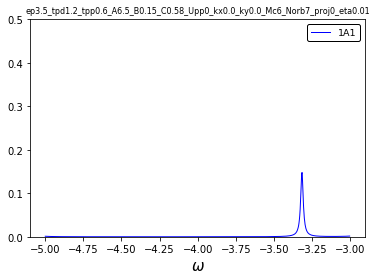

In [1]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
from scipy import integrate
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import lanczos

M_PI = math.pi
Mc  = pam.Mc
print 'Mc=',Mc

w_vals = pam.w_vals
Norb = pam.Norb
eta = pam.eta
ed  = pam.ed
project = pam.if_project_out_two_holes_on_different_Cu

if Norb==9:
    pds = pam.pds
    pdp = pam.pdp
    pps = pam.pps
    ppp = pam.ppp

if Norb==3:
    Udd = pam.Udd
elif Norb==7 or Norb==9:
    A = pam.A
    B = pam.B
    C = pam.C
                    
Ms = ['-b','-r','-g','-m','-c','-k','-y','--b','--r','--g','--m','--c','--k','--y',\
      '-.b','-.r','-.g','-.m','-.c','-.k','-.y',':b',':r',':g',':m',':c',':k',':y']
#####################################
def write_Aw(fname,Aw):
    f = open('./data_Aw/'+fname,'w',1) 
    f.write('#omega\tspectral weight\n')
    for i in xrange(0,len(w_vals)):
        f.write('{:.6e}\t{:.6e}\n'.format(float(w_vals[i]),Aw[i]))
        
def write_lowpeak_ep_tpd(fname,ep,tpd,w_peak,weight):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_lowpeak/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(ep, tpd, w_peak, weight))
    
def write_lowpeak_and_GS(fname,ep,tpd,w_peak,weight,E_gs):
    #"a" - Append - will append to the end of the file
    #"w" - Write - will overwrite any existing content
    f = open('./data_lowpeak/'+fname,'a',1) 
    f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(ep, tpd, w_peak, weight, E_gs))
    
def write_1A1_dispersion(fname,kxs,kys, w_max_k, Aw_max_k):
    f = open('./data_1A1_lowest_peak_dispersion/'+fname+'.txt','w',1) 
    f.write('kx   ky   E_lowest_peak   weight_lowest_peak\n')
    for i in xrange(0,len(w_max_k)):
        f.write('{:.6e}\t{:.6e}\t{:.6e}\t{:.6e}\n'.format(kxs[i],kys[i],w_max_k[i],Aw_max_k[i]))
        
def getAw(matrix,index,VS,w_vals,flowpeak,ep,tpd,E_gs):  
    # set up Lanczos solver
    dim  = VS.dim
    scratch = np.empty(dim, dtype = complex)
    Phi0 = np.zeros(dim, dtype = complex)
    Phi0[index] = 1.0
    solver = lanczos.LanczosSolver(maxiter = pam.Lanczos_maxiter, 
                                   precision = 1e-12, 
                                   cond = 'UPTOMAX', 
                                   eps = 1e-8)
    solver.first_pass(x0 = Phi0, scratch = scratch, H = matrix)
    V, D = solver.lanczos_diag_T()

    # D[0,:] is the eigenvector for lowest eigenvalue
    tab = np.abs(D[0,:])**2

    Aw = np.zeros(len(w_vals))
    for n in range(len(V)):
        Aw += tab[n] * eta / M_PI * ( (w_vals - V[n])**2 + eta**2)**(-1)
        
    w_peak, weight = getAw_peak_pos_weight(Aw, D, tab)
            
    # write data into file
    if pam.if_write_lowpeak_ep_tpd == 1:
        if pam.if_get_ground_state==1:
            write_lowpeak_and_GS(flowpeak,ep,tpd,w_peak,weight,E_gs)
        else:
            write_lowpeak(flowpeak,ep,tpd,w_peak,weight)
            
    return Aw, w_peak, weight

def getAw_peak_pos_weight(Aw, D, tab):  
    '''
    find the position and weight of lowest peak of Aw
    used to explore their dispersion in the high symmetry points in BZ
    '''    
    w_idx = np.argmax(Aw)
    w_peak = w_vals[w_idx]
    print 'w_lowpeak = ', w_peak
    
    # find the area below the whole peak, namely the peak weight
    # ==========================================================
    # 1. first find the peak's w-range: [w_min, w_max]
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid-1]>Aw[wid]:
            break
        wid -= 1
    w_min = wid
    
    wid = w_idx
    while Aw[wid]>1.e-3:
        #print w_vals[wid], Aw[wid]
        if Aw[wid+1]>Aw[wid]:
            break
        wid += 1
    w_max = wid
    
    print 'peak w-range = [', w_vals[w_min], w_vals[w_max], ']'
    
    # 2. Simpson's rule
    weight = integrate.simps(Aw[w_min:w_max], w_vals[w_min:w_max])
    print 'peak, weight = ', w_peak, '  ', weight
                          
    '''
    # find the eigenvalue D[n] nearest to w_peak so that its index n
    # leads to weight = tab[n]; Note that this weight is actually for 
    # the single peak instead of the area below the whole peak
    tmp = []
    for n in range(len(D)):
        tmp.append(abs(D[n]-w_peak))
        
    idx = tmp.index(min(tmp))
    weight = tab[idx]
    assert(weight>=0.0 and weight<=1.0)
    '''
    return w_peak, weight

def get_ground_state(matrix,S_val,Sz_val):  
    '''
    Obtain the ground state info, namely the lowest peak in Aw_dd's component
    in particular how much weight of various d8 channels: a1^2, b1^2, b2^2, e^2
    '''        
    print 'start getting ground state'
    # in case eigsh does not work but matrix is actually small, e.g. Mc=1 (CuO4)
    #M_dense = matrix.todense()
    #vals, vecs = np.linalg.eigh(M_dense)
    
    # in case eigsh works:
    Neval = pam.Neval
    vals, vecs = sps.linalg.eigsh(matrix, k=Neval, which='SA')
    print 'lowest eigenvalue of H = ', vals
    
    # get state components in GS and another 9 higher states; note that indices is a tuple
    for k in xrange(0,Neval):
        print 'eigenvalue = ', vals[k]
        indices = np.nonzero(abs(vecs[:,k])>0.05)

        print "Compute the weights in GS (lowest Aw peak)"
        for i in indices[0]:
            # state is original state but its orbital info remains after basis change
            state = VS.get_state(VS.lookup_tbl[i])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            x1, y1 = state['hole1_coord']
            x2, y2 = state['hole2_coord']

            # also obtain the total S and Sz of the state
            S12  = S_val[i]
            Sz12 = Sz_val[i]

            o12 = sorted([o1,o2])
            o12 = tuple(o12)
            
            #if abs(x1)>1. or abs(y1)>1. or abs(x2)>1. or abs(y2)>1.:
            #    continue            
            print 'state ', o12[0],x1,y1,o12[1],x2,y2, 'S=',S12,'Sz=',Sz12, \
                  ", weight = ", abs(vecs[i,k])**2
    return vals, vecs

def get_state_from_(spinorb):
    s1 = spinorb[0]
    o1 = spinorb[1]
    s2 = spinorb[2]
    o2 = spinorb[3]
    xy1 = lat.orb_pos[o1]
    xy2 = lat.orb_pos[o2]
    state = vs.create_state(s1,o1,xy1[0],xy1[1],s2,o2,xy2[0],xy2[1])
    print "candidate state: ", s1,o1,xy1[0],xy1[1],s2,o2,xy2[0],xy2[1]
    canonical_state,_ = vs.make_state_canonical(state)
    s1 = canonical_state['hole1_spin']
    s2 = canonical_state['hole2_spin']
    o1 = canonical_state['hole1_orb']
    o2 = canonical_state['hole2_orb']
    x1, y1 = canonical_state['hole1_coord']
    x2, y2 = canonical_state['hole2_coord']
    print "computing A(w) for canonical_state: ", s1,o1,x1,y1,s2,o2,x2,y2
    return canonical_state

def plot_atomic_multiplet_peaks(data_for_maxval):
    maxval = max(data_for_maxval)
    yy = [0,maxval]
    xx = [pam.E_1S,pam.E_1S]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1S-0.2, 10.2, 'E_1S', fontsize=5)
    xx = [pam.E_1G,pam.E_1G]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1G-0.2, 10.5, 'E_1G', fontsize=5)
    xx = [pam.E_1D,pam.E_1D]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1D-0.2, 10.8, 'E_1D', fontsize=5)
    xx = [pam.E_3P,pam.E_3P]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3P-0.2, 11.1, 'E_3P', fontsize=5)
    xx = [pam.E_3F,pam.E_3F]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3F-0.2, 11.4, 'E_3F', fontsize=5)
            
def compute_Aw_others(pam_flag,ham_func,fig_name):
    if pam_flag == 1:
        state_indices = ham_func(VS)

        print "===================================="
        clf()
        Nstate = len(state_indices)
        for j in range(0,Nstate):
            index = state_indices[j]
            Aw, w_peak, weight = getAw(H,index,VS,w_vals)           

            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-5,20])
            xlim([0,15])
            #ylim([0,maxval])
            ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        savefig(fig_name+fname+".pdf")

def checkU_unitary(U,U_d):
    UdU = U_d.dot(U)
    sh = UdU.shape
    print sh
    bb = sps.identity(sh[0], format='coo')
    tmp = UdU-bb
    print 'U_d.dot(U)-I = '
    for ii in range(0,sh[0]):
        for jj in range(0,sh[1]):
            if tmp[ii,jj]>1.e-10:
                print tmp[ii,jj]
                
def compute_Aw_main(VS,kx,ky,ep,tpd,tpp,Upp,d_double,p_double,U, U_d,S_val, Sz_val, AorB_sym): 
    if Norb==3:
        fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+ \
                    '_Udd'+str(Udd)+'_Upp'+str(Upp)+'_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                    '_proj'+str(project)+'_eta'+str(eta)
        flowpeak = 'Norb'+str(Norb)+'_tpp'+str(tpp)+'_Udd'+str(Udd)+'_Upp'+str(Upp)+ \
                   '_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_proj'+str(project)+'_eta'+str(eta)+'.txt'
    elif Norb==7:
        fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
                  +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                  +'_Upp'+str(Upp)+'_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                    '_proj'+str(project)+'_eta'+str(eta)
        flowpeak = 'Norb'+str(Norb)+'_1A1_tpp'+str(tpp)+'_A'+str(A)+'_B'+str(B)+'_C'+str(C)+'_Upp'+str(Upp)+ \
                   '_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_proj'+str(project)+'_eta'+str(eta)+'.txt'
    elif Norb==9:
        fname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
                  +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                  +'_Upp'+str(Upp)+'_kx'+str(kx)+'_ky'+str(ky)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                    '_proj'+str(project)+'_eta'+str(eta)
                
    # set up H0
    phase = ham.create_phase_dict(kx,ky,VS)
    tpd_nn_hop_dir, if_tpd_nn_hop, tpd_nn_hop_fac, tpp_nn_hop_fac = ham.set_tpd_tpp(Norb,tpd,tpp,0,0,0,0)
    T_pd  = ham.create_tpd_nn_matrix(phase,VS,tpd_nn_hop_dir, if_tpd_nn_hop, tpd_nn_hop_fac)
    T_pp  = ham.create_tpp_nn_matrix(phase,VS,tpp_nn_hop_fac)       
    Esite = ham.create_edep_diag_matrix(VS,ep)
    H0 = T_pd + T_pp + Esite
    
    # check_hermitian for H0
    #H0_max = H0.todense()
    #if ham.check_hermitian(H0_max):
    #    print 'hermitian'

    H0_new = U_d.dot(H0.dot(U))
    
    # for multi d-orbital cases, compute A(w) for each symmetry channel
    Aw = np.zeros(len(w_vals))
    Aw_dd_total = np.zeros(len(w_vals))
    Aw_d8_total = np.zeros(len(w_vals))
    
    clf()
    #======================= start opt for Norb=3 or 7, 9 ======================================
    if Norb==3:
        Hint, Aw_state_indices = ham.create_interaction_matrix_Norb3(VS,d_double,p_double,Upp)
        H = H0_new + Hint
        H.tocsr()
        
        if pam.if_get_ground_state==1:
            vals, vecs = get_ground_state(H, S_val, Sz_val)
            
        # For debug: check if H is hermitian: only practical for small Mc, namely small matrix
        #out_mat = H.todense()
        #assert(ham.check_hermitian(out_mat)==True)
        
        Nstate = len(Aw_state_indices)
        for j in range(0,Nstate):
            index = Aw_state_indices[j]
            
            if pam.if_get_ground_state==1:
                Aw, w_peak, weight = getAw(H,index,VS,w_vals,flowpeak,ep,tpd,vals[0])  
            else:
                Aw, w_peak, weight = getAw(H,index,VS,w_vals,flowpeak,ep,tpd,_)        

            # write data into file for reusage
            if pam.if_write_Aw == 1:
                write_Aw(fname+'.txt',Aw)
            
            state = VS.get_state(VS.lookup_tbl[index])
            s1 = state['hole1_spin']
            s2 = state['hole2_spin']
            o1 = state['hole1_orb']
            o2 = state['hole2_orb']
            
            #subplot(Nstate,1,j+1)
            plt.plot(w_vals, Aw, Ms[j], linewidth=1, label=tuple([s1,o1,s2,o2]))

            maxval = max(Aw)
            #xlim([-5,20])
            #ylim([0,maxval])
            #ylim([0,0.5])
            #ylabel('$A(\omega)$',fontsize=14)
            #text(0.45, 0.1, '(a)', fontsize=16)
            grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=6.5, framealpha=1.0, edgecolor='black')
            if j==0:
                title(fname, fontsize=8)
            if j==Nstate-1:
                xlabel('$\omega$',fontsize=15)

        if pam.if_savefig_Aw==1:
            savefig("Aw_"+fname+".pdf")

        # plot Matlab data for comparison
        #a = np.loadtxt('../data/dataMatlab.txt',skiprows=1)
        #la = len(a)
        #print la
        #plt.plot(a[0:la/3-1,0], a[0:la/3-1,1], '--c', linewidth=1, label='dd, Matlab')
        #plt.plot(a[la/3:2*la/3-1,0], a[la/3:2*la/3-1,1], '--m', linewidth=1, label='dp, Matlab')
        #plt.plot(a[2*la/3:la-1,0], a[2*la/3:la-1,1], '--k', linewidth=1, label='pp, Matlab')

    elif Norb==7 or Norb==9:
        Nsym = len(pam.symmetries)
        for i in range(0,Nsym):
            sym = pam.symmetries[i]
            print "===================================="
            print "start computing A_dd(w) for sym", sym
            Hint, dd_state_indices = ham.create_interaction_matrix(VS,sym,d_double,p_double, \
                                                                   S_val, Sz_val, AorB_sym, Upp)
            H = H0_new + Hint  
            H.tocsr()
            
            if pam.if_get_ground_state==1:
                vals, vecs = get_ground_state(H, S_val, Sz_val)
                
            #dd_states, d8_states, coef_frac_parentage = ham.get_Aw_state(sym)
            
            # compute G_dd(sym)
            Aw_dGS = np.zeros(len(w_vals))
            # G.S. weight 
            wgh_d = 0.57396723003
            wgh_p = 0.2130163839
            
            Aw_dd  = np.zeros(len(w_vals))
            Aw_d8  = np.zeros(len(w_vals))
        
            for index in dd_state_indices:
                if pam.if_get_ground_state==1:
                    Aw_tmp, w_peak, weight = getAw(H,index,VS,w_vals,flowpeak,ep,tpd,vals[0])  
                else:
                    Aw_tmp, w_peak, weight = getAw(H,index,VS,w_vals,flowpeak,ep,tpd,_)

                Aw_dd  += Aw_tmp  #*coef_frac_parentage[spinorb]
                #Aw_dGS += wgh_d*Aw_tmp
                
            # compute G_d_GS(sym) as in Eq.(13) in Eskes's PRB 1990 paper
            #Cu_dx2y2_O_indices = ham.get_Cu_dx2y2_O_indices(VS)
            #for ind in Cu_dx2y2_O_indices:
            #    Aw_tmp = getAw(H,ind,VS,w_vals)
            #    Aw_dGS += wgh_p*Aw_tmp  
                
            # accumulate Aw for each sym into total Aw_dd
            Aw_dd_total += Aw_dd
            
            # write data into file for reusage
            if pam.if_write_Aw == 1:
                write_Aw(fname+'_'+sym+'.txt', Aw_dd)
              
            subplot(Nsym,1,i+1)
            plt.plot(w_vals, Aw_dd, Ms[i], linewidth=1, label=sym)
            #plt.plot(w_vals, Aw_dGS, Ms[i], linewidth=1, label=sym)
            
            # plot atomic multiplet peaks
            #plot_atomic_multiplet_peaks(Aw_dd)
                
            if i==0:
                title(fname, fontsize=8)
            if i==Nsym-1:
                xlabel('$\omega$',fontsize=15)
                
            #xlim([-5,20])
            #xlim([-7.5,13])
            ylim([0,0.5])
            #ylim([0,maxval])
            #ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
            #yticks(fontsize=12)   
        
        if pam.if_savefig_Aw==1:    
            savefig("Aw_dd_"+fname+"_sym.pdf")
        
        ############################################################
        # plot total Gdd
        if pam.if_compute_Aw_dd_total == 1:
            clf()
            plt.plot(w_vals, Aw_dd_total,'-b', linewidth=1)
            title(fname, fontsize=8)
            maxval = max(Aw_dd_total)
            xlim([-5,0])
            ylim([0,maxval])
            xlabel('$\omega$',fontsize=17)
            ylabel('$A(\omega)$',fontsize=17)
            #text(0.45, 0.1, '(a)', fontsize=16)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')

            # plot atomic multiplet peaks
            plot_atomic_multiplet_peaks(Aw_dd_total)

            savefig("Aw_dd_"+fname+"_total.pdf")
    #########################################################################
    # compute G_pp and plot
    compute_Aw_others(pam.if_compute_Aw_pp, ham.get_pp_state_indices, "Aw_pp_")

    # compute G_dp and plot
    compute_Aw_others(pam.if_compute_Aw_dp, ham.get_dp_state_indices, "Aw_dp_")
    
    # compute G_Cu_O_dx2y2 and plot
    compute_Aw_others(pam.if_compute_Aw_Cu_dx2y2_O, ham.get_Cu_dx2y2_O_indices, "Aw_Cu_dx2y2_O_")
    
    return w_peak, weight

def set_k_grid(Nk):
    cnt = 0
    kxs = []
    kys = []    
    # from (0,0) to (pi,pi)
    for kx in np.arange(0.,M_PI,M_PI/Nk):
        ky = kx
        kxs.append(kx)
        kys.append(ky)
        cnt += 1
    # from (pi,pi) to (pi,0)
    for ky in np.arange(M_PI,0.,-M_PI/Nk):
        kx = M_PI
        kxs.append(kx)
        kys.append(ky)
        cnt += 1
    # from (pi,0) to (0,0)
    for kx in np.arange(M_PI,0.,-M_PI/Nk):
        ky = 0.0
        kxs.append(kx)
        kys.append(ky)
        cnt += 1
    return kxs, kys, cnt
        
##########################################################################
if __name__ == '__main__': 
    if Norb==9:
        sys.exit('This program basically mainly applies for Norb=3 and 7!')
                
    # set up VS
    VS = vs.VariationalSpace(Mc)
    basis.count_VS(VS)
    
    d_double, p_double = ham.get_double_occu_list(VS)
    
    # change the basis for d_double states to be singlet/triplet
    if pam.basis_change_type=='all_states':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix(VS,d_double)
    elif pam.basis_change_type=='d_double':
        U, S_val, Sz_val, AorB_sym = basis.create_singlet_triplet_basis_change_matrix_d_double(VS,d_double)

    U_d = (U.conjugate()).transpose()
    # check if U if unitary
    #checkU_unitary(U,U_d)
     
    if pam.single_k_mode==1:
        kx = pam.kx; ky = pam.ky
    else:
        Nk = pam.Nk
        kxs, kys, cnt = set_k_grid(Nk)
        w_peak_k = []
        weight_k = []
    
    for ep in pam.eps:
        for tpd in pam.tpds:
            for tpp in pam.tpps:
                for Upp in pam.Upps:
                    if Norb==3:
                        kname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+ \
                                '_Udd'+str(Udd)+'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                                '_proj'+str(project)+'_eta'+str(eta)
                    elif Norb==7:
                        kname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp) \
                              +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                              +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                                '_proj'+str(project)+'_eta'+str(eta)
                    elif Norb==9:
                        kname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
                              +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                              +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+ \
                                '_proj'+str(project)+'_eta'+str(eta)
                
                    print '==================================================='
                    print 'ep=', ep, ' tpd=',tpd,' tpp=',tpp,' Upp=',Upp 
                        
                    if pam.single_k_mode==1:
                        compute_Aw_main(VS,kx,ky, ep,tpd,tpp,Upp,d_double,p_double,U,U_d,S_val, Sz_val, AorB_sym)
                    else:
                        # below get 1A1 lowest peak dispersion
                        for ik in range(0,cnt):
                            kx = kxs[ik]; ky = kys[ik]
                            print '--------- k=[', kx, ky, ']--------------'
                            w_peak, weight = \
                            compute_Aw_main(VS,kx,ky, ep,tpd,tpp,Upp,d_double,p_double,U,U_d,S_val, Sz_val, AorB_sym)
                            w_peak_k.append(w_peak)
                            weight_k.append(weight)

                        # record data
                        if pam.if_write_1A1_dispersion == 1:
                            write_1A1_dispersion(kname,kxs,kys,w_peak_k, weight_k)

                        clf()
                        plt.plot(arange(0,cnt),w_peak_k,'-ko')

                        title(kname, fontsize=8)
                        xlabel('$k$',fontsize=17)
                        ylabel('1A1 lowpeak E',fontsize=14)
                        xticks((0,Nk,2.*Nk,3.*Nk), (r'$\Gamma$','M','X',r'$\Gamma$'))
                        #text(0.45, 0.1, '(a)', fontsize=16)
                        grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
                        legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
                        if pam.if_savefig_1A1_dispersion==1:
                            savefig("1A1_lowpeak_E_dispersion_"+kname+".pdf")

                        clf()
                        plt.plot(arange(0,cnt),weight_k,'-ko')

                        title(kname, fontsize=8)
                        xlabel('$k$',fontsize=17)
                        ylabel('1A1 lowpeak weight',fontsize=14)
                        xticks((0,Nk,2.*Nk,3.*Nk), (r'$\Gamma$','M','X',r'$\Gamma$'))
                        #text(0.45, 0.1, '(a)', fontsize=16)
                        grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
                        legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
                        if pam.if_savefig_1A1_dispersion==1:
                            savefig("1A1_lowpeak_weight_dispersion_"+kname+".pdf")